In [1]:
import pandas as pd
import numpy as np
import shapely
import geojson
import geopandas as gpd
import math
from pyproj import Geod
import matplotlib.pyplot as plt

In [2]:
pd.options.display.float_format = '{:.4f}'.format

# Part 1: Prepare Avg distance calculation

## Prepare Data

**Read-In LOR shapes Charlottenburg-Wilmersdorf**

In [3]:
df_lor = pd.DataFrame(gpd.read_file('lor_cw.geojson'))

In [4]:
df_lor.head(3)

,gml_id,spatial_name,spatial_alias,spatial_type,PLRNAME,BZRNAME,PGRNAME,BEZNAME,DATUM,SHAPE_AREA,geometry
0,re_planungsraum.04010101,04010101,Jungfernheide,Polygon,Jungfernheide,Charlottenburg Nord,CW 1,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,3066535.9995,"POLYGON ((13.27033 52.54935, 13.27033 52.54922..."
1,re_planungsraum.04010102,04010102,Plötzensee,Polygon,Plötzensee,Charlottenburg Nord,CW 1,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,2167532.1210,"POLYGON ((13.29729 52.54295, 13.29808 52.54279..."
2,re_planungsraum.04010103,04010103,Paul-Hertz-Siedlung,Polygon,Paul-Hertz-Siedlung,Charlottenburg Nord,CW 1,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,555870.0931,"POLYGON ((13.29423 52.53273, 13.29481 52.53287..."


In [5]:
df_lor.gml_id.count()

57

In [6]:
df_lor.SHAPE_AREA.sum()/1000000

64.66365606656844

**Convert geometry column to geojson column**

In [7]:
def to_geojson(geometry):
    
    points = str(geometry).replace('(','').replace(')','').replace('POLYGON ','').split(', ')
    
    coordinates = list()
    
    for string in points:
        
        lat_lon = string.split(' ')
        lat_lon[0] = float(lat_lon[0])
        lat_lon[1] = float(lat_lon[1])
        
        coordinates.append(lat_lon)
        
    geojson= list([coordinates])
    return {"type": "Polygon", "coordinates": geojson}

df_lor['geojson'] = df_lor.geometry.apply(lambda x: to_geojson(x))
df_lor.head(3)

,gml_id,spatial_name,spatial_alias,spatial_type,PLRNAME,BZRNAME,PGRNAME,BEZNAME,DATUM,SHAPE_AREA,geometry,geojson
0,re_planungsraum.04010101,04010101,Jungfernheide,Polygon,Jungfernheide,Charlottenburg Nord,CW 1,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,3066535.9995,"POLYGON ((13.27033 52.54935, 13.27033 52.54922...","{'type': 'Polygon', 'coordinates': [[[13.27033..."
1,re_planungsraum.04010102,04010102,Plötzensee,Polygon,Plötzensee,Charlottenburg Nord,CW 1,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,2167532.1210,"POLYGON ((13.29729 52.54295, 13.29808 52.54279...","{'type': 'Polygon', 'coordinates': [[[13.29728..."
2,re_planungsraum.04010103,04010103,Paul-Hertz-Siedlung,Polygon,Paul-Hertz-Siedlung,Charlottenburg Nord,CW 1,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,555870.0931,"POLYGON ((13.29423 52.53273, 13.29481 52.53287...","{'type': 'Polygon', 'coordinates': [[[13.29422..."


**Read-In LOR structural data Charlottenburg Wilmersdorf**

In [8]:
df_lor_data = pd.read_csv('EWR201812E_Matrix.csv', sep=';', dtype={'RAUMID': str})
df_lor_data.head(3)

,ZEIT,RAUMID,BEZ,PGR,BZR,PLR,STADTRAUM,E_E,E_EM,E_EW,...,E_E95_110,E_EU1,E_E1U6,E_E6U15,E_E15U18,E_E18U25,E_E25U55,E_E55U65,E_E65U80,E_E80U110
0,201812,01011101,1,1,11,1,1,3384,1751,1633,...,6,27,151,120,38,322,1616,383,542,185
1,201812,01011102,1,1,11,2,1,196,127,69,...,0,0,3,3,3,12,115,38,22,0
2,201812,01011103,1,1,11,3,1,5038,2698,2340,...,21,48,195,325,109,412,2281,742,694,232


## Merge Data

**Merge CH shapes with CH structural data**

In [9]:
df_lor = df_lor.merge(df_lor_data[['RAUMID','E_E']], left_on='spatial_name', right_on='RAUMID')

**Select, order and rename columns**

In [10]:
df_lor = df_lor[['spatial_name','spatial_alias', 'SHAPE_AREA', 'E_E', 'geometry', 'geojson']]

In [11]:
df_lor.rename(columns={"spatial_name": "neighbourhood_id", 
                       "spatial_alias": "neighbourhood_name", 
                       "SHAPE_AREA": "area",
                       "E_E": "pop"
                      }, inplace=True)

In [12]:
df_lor.head(3)

,neighbourhood_id,neighbourhood_name,area,pop,geometry,geojson
0,04010101,Jungfernheide,3066535.9995,10785,"POLYGON ((13.27033 52.54935, 13.27033 52.54922...","{'type': 'Polygon', 'coordinates': [[[13.27033..."
1,04010102,Plötzensee,2167532.1210,812,"POLYGON ((13.29729 52.54295, 13.29808 52.54279...","{'type': 'Polygon', 'coordinates': [[[13.29728..."
2,04010103,Paul-Hertz-Siedlung,555870.0931,7881,"POLYGON ((13.29423 52.53273, 13.29481 52.53287...","{'type': 'Polygon', 'coordinates': [[[13.29422..."


## Calculate pre-measures

**Calculate population density**

In [13]:
df_lor['area'] = df_lor['area']/1000000

In [14]:
df_lor['pop_den'] = df_lor['pop']/ (df_lor['area'])

**Calculate scale factor 'pop share' based on population distribution**

In [15]:
df_lor['pop_sum'] = df_lor['pop'].sum()

In [16]:
df_lor['pop_share'] = df_lor['pop'] / df_lor['pop_sum']

In [17]:
df_lor.head(3)

,neighbourhood_id,neighbourhood_name,area,pop,geometry,geojson,pop_den,pop_sum,pop_share
0,04010101,Jungfernheide,3.0665,10785,"POLYGON ((13.27033 52.54935, 13.27033 52.54922...","{'type': 'Polygon', 'coordinates': [[[13.27033...",3516.9977,341327,0.0316
1,04010102,Plötzensee,2.1675,812,"POLYGON ((13.29729 52.54295, 13.29808 52.54279...","{'type': 'Polygon', 'coordinates': [[[13.29728...",374.6196,341327,0.0024
2,04010103,Paul-Hertz-Siedlung,0.5559,7881,"POLYGON ((13.29423 52.53273, 13.29481 52.53287...","{'type': 'Polygon', 'coordinates': [[[13.29422...",14177.7730,341327,0.0231


## Calculate avg distances from one lor to all other

**Get centroid coords**

In [18]:
def get_centroid(x):
    
    return [x.geometry.centroid.coords[0][0],x.geometry.centroid.coords[0][1]]

df_lor[['geo_center_lon','geo_center_lat']] = pd.DataFrame(df_lor.apply(lambda x: get_centroid(x), axis=1).tolist(), index=df_lor.index)

**Build all combinations via merge**

In [19]:
df_lor['mg'] = 1
df_dist = df_lor.merge(df_lor[['neighbourhood_id', 'geo_center_lat', 'geo_center_lon', 'mg']], on='mg')
df_dist = df_dist[['neighbourhood_id_x', 'neighbourhood_id_y', 'geo_center_lat_x', 'geo_center_lon_x', 'geo_center_lat_y', 'geo_center_lon_y']]
df_dist.head(3)

,neighbourhood_id_x,neighbourhood_id_y,geo_center_lat_x,geo_center_lon_x,geo_center_lat_y,geo_center_lon_y
0,04010101,04010101,52.5410,13.2855,52.5410,13.2855
1,04010101,04010102,52.5410,13.2855,52.5421,13.3122
2,04010101,04010103,52.5410,13.2855,52.5371,13.2995


In [20]:
df_dist = df_dist[df_dist.neighbourhood_id_x != df_dist.neighbourhood_id_y]

**Calculate all distances**

In [21]:
wgs84_geod = Geod(ellps='WGS84')

def distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
    return dist

df_dist['geo_dist'] = df_dist.apply(lambda x: distance(x.geo_center_lat_x, x.geo_center_lon_x, x.geo_center_lat_y, x.geo_center_lon_y), axis=1)
df_dist.head(3)

,neighbourhood_id_x,neighbourhood_id_y,geo_center_lat_x,geo_center_lon_x,geo_center_lat_y,geo_center_lon_y,geo_dist
1,04010101,04010102,52.5410,13.2855,52.5421,13.3122,1817.8002
2,04010101,04010103,52.5410,13.2855,52.5371,13.2995,1042.6567
3,04010101,04020204,52.5410,13.2855,52.5177,13.2324,4436.9082


**Calculate avg distance per hexagon**

In [22]:
df_dist = df_dist.groupby(['neighbourhood_id_x']).agg({'geo_dist': 'mean'}).reset_index()

In [23]:
df_dist.head(3)

,neighbourhood_id_x,geo_dist
0,04010101,4985.5787
1,04010102,5196.0255
2,04010103,4571.8767


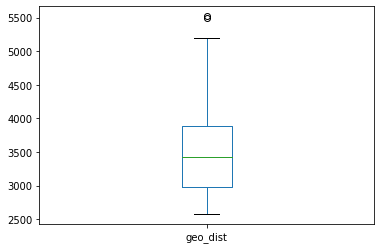

In [24]:
plt.figure()
df_dist.geo_dist.plot.box()

**Merge to lor table**

In [25]:
df_lor = df_lor.merge(df_dist, left_on='neighbourhood_id', right_on='neighbourhood_id_x').drop(columns=['mg', 'neighbourhood_id_x'])
df_lor.rename(columns={'geo_dist': 'geo_dist_out_avg'}, inplace=True)

In [26]:
df_lor.head(3)

,neighbourhood_id,neighbourhood_name,area,pop,geometry,geojson,pop_den,pop_sum,pop_share,geo_center_lon,geo_center_lat,geo_dist_out_avg
0,04010101,Jungfernheide,3.0665,10785,"POLYGON ((13.27033 52.54935, 13.27033 52.54922...","{'type': 'Polygon', 'coordinates': [[[13.27033...",3516.9977,341327,0.0316,13.2855,52.5410,4985.5787
1,04010102,Plötzensee,2.1675,812,"POLYGON ((13.29729 52.54295, 13.29808 52.54279...","{'type': 'Polygon', 'coordinates': [[[13.29728...",374.6196,341327,0.0024,13.3122,52.5421,5196.0255
2,04010103,Paul-Hertz-Siedlung,0.5559,7881,"POLYGON ((13.29423 52.53273, 13.29481 52.53287...","{'type': 'Polygon', 'coordinates': [[[13.29422...",14177.7730,341327,0.0231,13.2995,52.5371,4571.8767


**Assume factor 1.3 for street distance from beeline distance**

In [27]:
beeline_dist_factor = 1.3

In [28]:
df_lor['street_dist_out_avg'] = beeline_dist_factor * df_lor['geo_dist_out_avg']

In [29]:
df_lor.head(3)

,neighbourhood_id,neighbourhood_name,area,pop,geometry,geojson,pop_den,pop_sum,pop_share,geo_center_lon,geo_center_lat,geo_dist_out_avg,street_dist_out_avg
0,04010101,Jungfernheide,3.0665,10785,"POLYGON ((13.27033 52.54935, 13.27033 52.54922...","{'type': 'Polygon', 'coordinates': [[[13.27033...",3516.9977,341327,0.0316,13.2855,52.5410,4985.5787,6481.2523
1,04010102,Plötzensee,2.1675,812,"POLYGON ((13.29729 52.54295, 13.29808 52.54279...","{'type': 'Polygon', 'coordinates': [[[13.29728...",374.6196,341327,0.0024,13.3122,52.5421,5196.0255,6754.8331
2,04010103,Paul-Hertz-Siedlung,0.5559,7881,"POLYGON ((13.29423 52.53273, 13.29481 52.53287...","{'type': 'Polygon', 'coordinates': [[[13.29422...",14177.7730,341327,0.0231,13.2995,52.5371,4571.8767,5943.4398


# Part 2: Calculate Min Distance and Avg Distance based on orders

In [30]:
df_lor[['neighbourhood_id', 'neighbourhood_name', 'area', 'pop', 'pop_den', 'pop_share', 'geo_dist_out_avg', 'street_dist_out_avg']].head(3)

,neighbourhood_id,neighbourhood_name,area,pop,pop_den,pop_share,geo_dist_out_avg,street_dist_out_avg
0,04010101,Jungfernheide,3.0665,10785,3516.9977,0.0316,4985.5787,6481.2523
1,04010102,Plötzensee,2.1675,812,374.6196,0.0024,5196.0255,6754.8331
2,04010103,Paul-Hertz-Siedlung,0.5559,7881,14177.7730,0.0231,4571.8767,5943.4398


**Read-In avg. orders numbers**

In [31]:
distances_year = pd.DataFrame({'year':[2021, 2022, 2023], 'orders':[498, 1668, 3305]})

In [33]:
distances_year['orders'] = distances_year['orders']*(1/1.5)
distances_year['orders_per_shift'] = distances_year['orders']/2
distances_year.head(3)

,year,orders,orders_per_shift
0,2021,221.3333,110.6667
1,2022,741.3333,370.6667
2,2023,1468.8889,734.4444


In [34]:
distances_weeks = pd.read_csv('order_development.csv', sep=';')
distances_weeks['orders'] = distances_weeks['orders']*(1/1.5)
distances_weeks['orders_per_shift'] = distances_weeks['orders']/2
distances_weeks

,CW,orders,orders_per_shift
0,105,10.6667,5.3333
1,106,21.3333,10.6667
2,107,32.0000,16.0000
3,108,42.6667,21.3333
4,109,53.3333,26.6667
...,...,...,...
151,256,2722.0000,1361.0000
152,257,2747.3333,1373.6667
153,258,2772.6667,1386.3333
154,259,2798.6667,1399.3333


**Define def for min distance**

In [35]:
def min_distance(area, orders):
    
    if orders != 0:
        return 2*(math.sqrt((area/orders)/(2*math.sqrt(3))))
    else:
        return np.nan

**Define def for avg distance**

In [36]:
def dist_rescale(x):
        
    if x.orders > 1:
        return (x.dist_inside * x.con_inside + x.street_dist_out_avg * x.con_out)/ (x.con_inside + x.con_out)
    else:
        return 0


def avg_distance(orders):
    
    df_lor['orders'] = (orders * df_lor['pop_share'])
    con_gesamt = math.pow(df_lor['orders'].sum(),2)-df_lor['orders'].sum()
    df_lor['con_inside'] = df_lor.apply(lambda x: math.pow(x.orders, 2)-x.orders, axis=1)
    df_lor['con_out'] = (orders - df_lor['orders'])*df_lor['orders']
    
    df_lor['dist_inside'] = df_lor.apply(lambda x: min_distance(x.area, x.orders), axis =1)
    
    df_lor['street_dist_avg_rescaled'] = df_lor.apply(lambda x: dist_rescale(x), axis=1)
     
    avg_distance = (df_lor[df_lor.orders >= 1]['street_dist_avg_rescaled'] * df_lor[df_lor.orders >= 1]['orders']).sum()/df_lor[df_lor.orders >= 1]['orders'].sum()
    
    df_lor.drop(columns=['orders', 'con_inside', 'con_out', 'dist_inside', 'street_dist_avg_rescaled'])
    
    return avg_distance/1000

In [37]:
distances_year['min_dist'] = distances_year.orders_per_shift.apply(lambda x: min_distance(64.72, x))
distances_weeks['min_dist'] = distances_weeks.orders_per_shift.apply(lambda x: min_distance(64.72, x))

In [38]:
distances_year['avg_distance'] = distances_year.orders_per_shift.apply(lambda x: avg_distance(x))
distances_weeks['avg_distance'] = distances_weeks.orders_per_shift.apply(lambda x: avg_distance(x))

In [39]:
distances_year

,year,orders,orders_per_shift,min_dist,avg_distance
0,2021,221.3333,110.6667,0.8218,4.1778
1,2022,741.3333,370.6667,0.4490,4.2415
2,2023,1468.8889,734.4444,0.3190,4.2433


In [40]:
distances_weeks.head(3)

,CW,orders,orders_per_shift,min_dist,avg_distance
0,105,10.6667,5.3333,3.7433,nan
1,106,21.3333,10.6667,2.6469,nan
2,107,32.0000,16.0000,2.1612,nan


In [41]:
distances_year['distance'] = 0.95 * distances_year['min_dist'] + 0.05 * distances_year['avg_distance']
distances_weeks['distance'] = 0.95 * distances_weeks['min_dist'] + 0.05 * distances_weeks['avg_distance']

In [42]:
distances_year.to_csv('distances_year.csv', sep=';', decimal=',')

In [43]:
distances_weeks.to_csv('distances_weeks.csv', sep=';', decimal=',')

In [44]:
distances_year

,year,orders,orders_per_shift,min_dist,avg_distance,distance
0,2021,221.3333,110.6667,0.8218,4.1778,0.9896
1,2022,741.3333,370.6667,0.4490,4.2415,0.6386
2,2023,1468.8889,734.4444,0.3190,4.2433,0.5152
